In [1]:
# just some housekeeping here... pay no mind.
from random import seed
from random import shuffle
import numpy as np
import pandas as pd
from time import time

from matplotlib import pyplot as plt
from matplotlib.ticker import FuncFormatter
%matplotlib inline

import WAR

# reload if updated script
# import importlib
# importlib.reload(WAR)

# Reaching a Stable State

## Run Simulations

Using original rules -- no discard randomness, discard mode is First In First Out.

In [2]:
# Simulate 1k games
results = []
seed(0)
for i in range(0, 1000):
    # Initialize a game
    game = WAR.War(max_hands = 20000, discard_recycle_mode = 'fifo', discard_randomness = False)
    
    # Play each game
    _ = game.play_game()
    
    # Append the game summary dict. (includes number of turns, winner, starting hands, etc.) to the results list
    results.append(game.summary)

In [3]:
# Turn results list into a dataframe
results_df = pd.DataFrame(results)

# Print the percent finished and show head
print('Percent finished: {:.0%}'.format(results_df.finished.mean()))
results_df.head()

Percent finished: 64%


,discard_randomness,discard_recycle_mode,finished,hands_played,p1_dealt,p2_dealt,tracks
0,False,fifo,True,781,"[4, 14, 8, 4, 14, 9, 7, 12, 3, 12, 9, 2, 6, 11...","[10, 3, 13, 12, 5, 6, 11, 10, 8, 3, 7, 10, 9, ...",0 26 1 25 2 26 3 25 4 ...
1,False,fifo,True,1170,"[2, 12, 3, 13, 10, 2, 13, 3, 5, 11, 7, 2, 14, ...","[14, 11, 6, 5, 2, 10, 9, 7, 8, 8, 7, 8, 13, 3,...",0 26 1 25 2 26 3 25 4 ...
2,False,fifo,True,839,"[5, 14, 6, 6, 5, 3, 11, 3, 11, 13, 10, 8, 4, 1...","[8, 3, 12, 14, 7, 12, 9, 9, 7, 11, 7, 4, 10, 4...",0 26 1 25 2 26 3 25 4 ...
3,False,fifo,True,1935,"[11, 13, 6, 14, 14, 7, 6, 9, 11, 7, 12, 12, 2,...","[2, 12, 3, 7, 5, 11, 8, 11, 3, 6, 5, 8, 3, 10,...",0 26 1 27 2 28 3 29 4 ...
4,False,fifo,True,152,"[12, 3, 14, 8, 8, 12, 11, 9, 3, 9, 14, 13, 6, ...","[9, 10, 13, 7, 7, 4, 10, 6, 10, 4, 10, 7, 5, 2...",0 26 1 27 2 26 3 27 4 ...


## Plot Game Tracks

Plot tracks for unfinished games -- demonstrate that never-ending games reach a stable state.

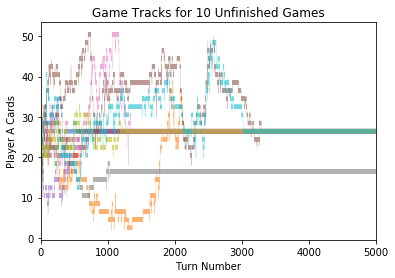

In [4]:
# Loop through the first 10 unfinished games and plot the tracks
for a in results_df.loc[~results_df.finished, 'tracks'].iloc[0:10]:
    _ = plt.plot(a, linewidth = 0.3, alpha = 0.6)

# Format the graphs
_ = plt.title('Game Tracks for 10 Unfinished Games')
_ = plt.xlabel('Turn Number')
_ = plt.xlim(0, 5000)
_ = plt.ylabel('Player A Cards')

# Save figure
_ = plt.savefig('post_2/game_tracks.png', dpi = 300)

## Find Where Stable States Occur

In [5]:
def stable_state(game_tracks):
    '''
    Finds whether the stable state has been reached and, if so, the turn when it was
    reached and how many cards player 1 had. If stable state has not been reached, returns
    False for stable_reached and np.NaN for stable_cards_p1 and stable_turn.
    '''
    
    # Checks whether stable has been reached by evaluating if there was any shift in the
    ## balance of cards in the last 52 recorded turns
    last52 = game_tracks.iloc[-52:]
    stable_reached = last52.max() - last52.min() == 1
    
    # Find the stable state turn and card count if stable state has been reached
    if stable_reached:
        # Find the stable state # of cards (use even number)
        last2 = game_tracks.iloc[-2:] # Look at last two card counts
        stable_cards_p1 = last2[last2 % 2 == 0].iloc[0] # Choose the one that is even
    
        # Find the number of turns to get to stable state
        game_tracks_rev = game_tracks.sort_index(ascending = False) # Reverse sort the game tracks
        outside_stable = abs(game_tracks_rev - stable_cards_p1) > 1
        stable_turn = game_tracks_rev[outside_stable].index[0] + 1  # Get index of last time game was
                                                                    # outside of the stable state
    
    # Otherwise, assign NaN
    else:
        stable_cards_p1, stable_turn = np.NaN, np.NaN
        
        
    
    return stable_reached, stable_cards_p1, stable_turn

In [6]:
# Test function
stable_state(results_df.loc[25, 'tracks'])

(True, 16, 1030)

In [7]:
# Apply the stable state function on the tracks of never-ending games
stable_state_cards = results_df.loc[~results_df['finished']].apply(
                                                lambda x: stable_state(x['tracks']), axis = 1, result_type = 'expand')

# Rename and show head
stable_state_cards.columns = ['stable_state_reached', 'stable_cards_p1', 'stable_turn']
stable_state_cards.head()

,stable_state_reached,stable_cards_p1,stable_turn
5,True,26,351
8,True,26,2159
9,True,26,537
10,True,26,715
16,True,26,571


In [8]:
# Show the percentage of stable state games by p1 cards
stable_state_cards.stable_cards_p1.value_counts().sort_index() / len(stable_state_cards)

8     0.002778
12    0.008333
16    0.016667
20    0.030556
24    0.013889
26    0.844444
28    0.011111
32    0.022222
36    0.022222
40    0.011111
44    0.013889
48    0.002778
Name: stable_cards_p1, dtype: float64

# Investigate a Stable State-26 Case

In [9]:
# Find the first never-ending game with a 26-26 stable state
game_index = stable_state_cards[stable_state_cards.stable_cards_p1 == 26].index[0]

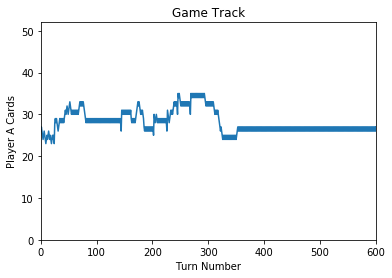

In [10]:
# Plot the game track
_ = plt.plot(results_df.loc[game_index, 'tracks'])
_ = plt.title('Game Track')
_ = plt.xlabel('Turn Number')
_ = plt.xlim(0, 600)
_ = plt.ylim(0, 52)
_ = plt.ylabel('Player A Cards')

_ = plt.savefig('post_2/game_track_26.png', dpi = 300)

In [11]:
# Find the starting hands for the game and initialize a game with those starting hands

starting_hands = [i for i in results_df.loc[game_index, ['p1_dealt', 'p2_dealt']]]
game = WAR.War(20000, 'fifo', starting_hands = starting_hands.copy())

In [12]:
# Find the stable state turn

stable_turn = stable_state_cards.loc[game_index, 'stable_turn']
stable_turn

351

In [13]:
# Move the game ahead to the stable state

game.seek(400)

,P1,P2
0,13,8
1,2,14
2,11,9
3,7,13
4,12,3
5,2,13
6,10,8
7,5,14
8,7,5
9,4,12


In [14]:
# Check 26 turns later to see the mirror

game.skip(26)

,P1,P2
0,13,2
1,8,14
2,11,7
3,9,13
4,12,2
5,3,13
6,10,5
7,8,14
8,7,4
9,5,12


In [15]:
# 26 more turns to return to the hands of turn 400

x = game.skip(52)
x

,P1,P2
0,13,2
1,8,14
2,11,7
3,9,13
4,12,2
5,3,13
6,10,5
7,8,14
8,7,4
9,5,12


## Confirm other 26-26 cases follow the stable state structure

In [16]:
def check_diagonals(diagonal_1, diagonal_2):
    '''
    If passed tuples for diagonals, will confirm that both cards in one tuple
    are larger than both tuples in the other (i.e. stable state block)
    '''
    sorted_tuples = sorted([diagonal_1, diagonal_2], key = sum)
    
    return max(sorted_tuples[0]) < min(sorted_tuples[1])

In [17]:
def check_game_structure(hands_df):
    '''
    Evaluates a dataframe representing both players hands to see if it follows
    the stable state pattern.
    '''
    hands_df = hands_df.copy()
    
    # Confirm we have a 26-26 stable state
    assert len(hands_df) == 26

    #Create tuples with the diagonals (current row and following row)
    hands_df['P1_shift'] = hands_df['P1'].shift(-1)
    hands_df['P2_shift'] = hands_df['P2'].shift(-1)  
    hands_df['diagonal_1'] = hands_df.apply(lambda row: (row['P1'], row['P2_shift']), axis = 1)
    hands_df['diagonal_2'] = hands_df.apply(lambda row: (row['P2'], row['P1_shift']), axis = 1)
    
    #Consider every other row (to deal with 4-card blocks)
    hands_df = hands_df.iloc[::2]
        
    return hands_df.apply(lambda x: check_diagonals(x['diagonal_1'], x['diagonal_2']), axis = 1).all()

In [18]:
check_game_structure(x)

True

In [19]:
# Initiate list to track results
structure_validate = []

# Loop through every game with a 26-26 stable state
for game_index in stable_state_cards[stable_state_cards.stable_cards_p1 == 26].index:
    
    # Initalize game
    starting_hands = [i for i in results_df.loc[game_index, ['p1_dealt', 'p2_dealt']]]
    game = WAR.War(20000, 'fifo', starting_hands = starting_hands.copy())
    
    # Move forward to the stable state
    stable_turn = stable_state_cards.loc[game_index, 'stable_turn']
    stable_turn = ((stable_turn + 52) // 2)*2
    hands = game.seek(stable_turn)
    
    # Check the game structure and append the result to the trackign list
    try:
        res = check_game_structure(hands)
        structure_validate.append(res)
    
    # Run one more turn if check game structure didn't work (not at 26-26) and rerun test
    except:
        hands = game.skip()
        res = check_game_structure(hands)
        structure_validate.append(res)

In [20]:
# Confirm that each 26-26 game passed the test
min(structure_validate)

True

## Investigating Other Stable States

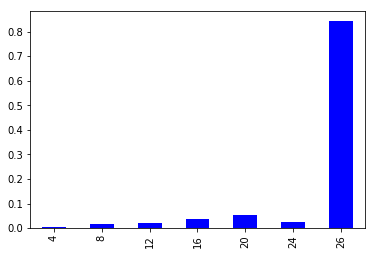

In [21]:
stable_state_counts = stable_state_cards.stable_cards_p1.apply(lambda x: 26 - abs(x - 26)).value_counts() / \
            len(stable_state_cards)

stable_state_counts.sort_index().plot.bar(color = 'blue')

In [22]:
game_index = stable_state_cards[stable_state_cards.stable_cards_p1.isin([4, 48])].index[0]
results_df.loc[game_index]

discard_randomness                                                  False
discard_recycle_mode                                                 fifo
finished                                                            False
hands_played                                                        20000
p1_dealt                [3, 12, 10, 10, 9, 11, 7, 6, 5, 9, 6, 2, 5, 8,...
p2_dealt                [4, 8, 11, 8, 5, 6, 9, 4, 14, 5, 3, 2, 10, 13,...
tracks                  0        26
1        25
2        26
3        2...
Name: 991, dtype: object

In [23]:
stable_turn = stable_state_cards.loc[game_index, 'stable_turn']
stable_turn

1677

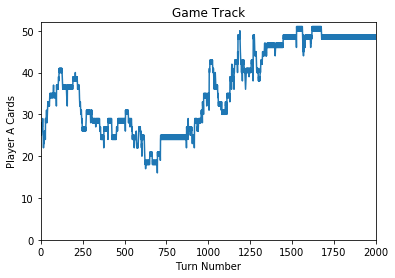

In [24]:
_ = plt.plot(results_df.loc[game_index, 'tracks'])
_ = plt.title('Game Track')
_ = plt.xlabel('Turn Number')
_ = plt.xlim(0, 2000)
_ = plt.ylim(0, 52)
_ = plt.ylabel('Player A Cards')

_ = plt.savefig('post_2/game_track_26.png', dpi = 300)

In [25]:
starting_hands = [i for i in results_df.loc[game_index, ['p1_dealt', 'p2_dealt']]]
game = WAR.War(20000, 'fifo', starting_hands = starting_hands.copy())

In [26]:
# Confirm stable-state like structure

x = game.seek(1800)
x

,P1,P2
0,14,6.0
1,5,9.0
2,12,4.0
3,6,8.0
4,10,NaN
5,2,NaN
6,10,NaN
7,7,NaN
8,14,NaN
9,3,NaN


In [27]:
# Similar structure maintained four turns later

game.skip(4)

,P1,P2
0,10,5.0
1,2,9.0
2,10,6.0
3,7,8.0
4,14,NaN
5,3,NaN
6,9,NaN
7,5,NaN
8,11,NaN
9,2,NaN


# Breaking the Stable State

Simulate games with discard randomness

In [28]:
seed(0)
for i in range(0, 1000):
    game = WAR.War(20000, 'fifo', True)
    _ = game.play_game()
    results.append(game.summary)

In [29]:
# Create a dataframe out of results and check the percentage of games finished
# by discard randomness

results_df = pd.DataFrame(results)
results_df.groupby('discard_randomness').finished.mean()

discard_randomness
False    0.64
True     1.00
Name: finished, dtype: float64

In [30]:
# Create a running percent distribution of finished games by turn count, grouped by randomness

running_dist = results_df.groupby('discard_randomness').hands_played.apply(
    lambda x: x.value_counts().sort_index().cumsum() / len(x))

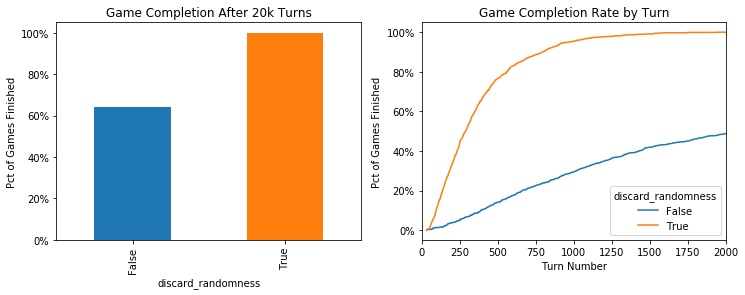

In [31]:
# Plot result comparison between original and random discard

fig, ax = plt.subplots(1, 2, figsize = (12, 4))

_ = results_df.groupby('discard_randomness').finished.mean().plot.bar(ax = ax[0])
_ = ax[0].set_ylabel('Pct of Games Finished')
_ = ax[0].set_title('Game Completion After 20k Turns')
_ = ax[0].yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y)))

_ = running_dist.unstack(level = 0).fillna(method = 'backfill').plot(ax = ax[1])
_ = ax[1].set_xlim(0, 2000)
_ = ax[1].set_xlabel('Turn Number')
_ = ax[1].set_ylabel('Pct of Games Finished')
_ = ax[1].set_title('Game Completion Rate by Turn')
_ = ax[1].yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y)))

plt.savefig('post_2/discard_randomness_comp.png', bbox_inches = 'tight', dpi = 300)

# Final Thoughts

In [51]:
john = [13, 11, 9, 12, 3, 8, 6, 5, 6, 5, 13, 6, 13, 4, 4, 6, 10, 4, 3, 2, 7, 10, 9, 3, 14, 2, 10, 2, 3, 12, 5, 2]
kelly = [8, 4, 9, 12, 7, 14, 8, 14, 8, 7, 5, 11, 10, 12, 7, 9, 13, 11, 14, 11]

In [58]:
turns_to_res = []
for i in range(0, 100):
    seed(i)
    game = WAR.War(20000, discard_recycle_mode = 'filo', discard_randomness = True,
                    starting_hands = [john.copy(), kelly.copy()])
    
    summary = game.play_game()
    
    turns_to_res.append(summary['hands_played'])

In [70]:
np.percentile(turns_to_res, [50, 75, 90, 99])

array([ 297.5 ,  535.5 ,  844.3 , 1159.27])